Unsupervised Training.. 0.0
Losses: [285842.60546875]
Epoch 0, loss: 285842.60546875, windowed_loss: 50
Network 1, Accuracy: 42.9769392033543%
Pre-Query Validation Complete. Accuracy: 42.9769392033543%


/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


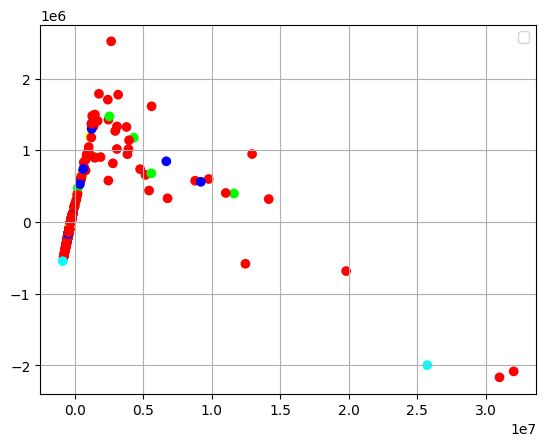

Unsupervised Training.. 0.0


KeyboardInterrupt: 

In [6]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scipy import ndimage
import torch
import time
import random
from data.swarmset import ContinuingDataset, SwarmDataset
from torchvision.transforms import RandomResizedCrop
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
import matplotlib.pyplot as plot
from networks.ensemble import Ensemble
import numpy as np
import cv2
from sklearn.manifold import TSNE

def CSVLineToVec(line):
    line_list = line.strip().replace("\n", "").split(",")
    float_list = []
    for i in line_list:
        float_list.append(float(i))
    float_list = np.array(float_list)
    return float_list

def visualize_projection(e):
    e.eval_mode()
    embeddings = []
    classes = []
    # for i in range(len(data)):
    for i in range(1000):
        image, _class = sampled_dataset[i][0], sampled_dataset[i][1][0]
        image = np.expand_dims(image, axis=0)
        embed = e.ensemble[0].forward(torch.tensor(image, device=device, dtype=torch.float))
        embed = embed.detach().cpu().squeeze(dim=0).numpy()
        embeddings.append(embed)
        classes.append(_class)

    embeddings = np.array(embeddings)

    reduced = TSNE(
        n_components=2,
        learning_rate="auto",
        init="pca",
        perplexity=40,
        early_exaggeration=1
    ).fit_transform(embeddings)

    color_classes = {
        -1: [0.33, 0.33, 0.33],
        0: [1, 0, 0],
        1: [0, 1, 0],
        2: [0, 0, 1],
        3: [0, 1, 1], # Cyan
        4: [1, 1, 0], # Yellow
        5: [0.5, 0, 0.25] # Pink
    }

    label_classes = {
        -1: "Unlabeled",
        0: "Random",
        1: "Cyclic Pursuit",
        2: "Milling",
        3: "Aggregation",
        4: "Dispersal",
        5: "Wall Following"
    }

    lim = len(reduced)
    classes = [-1 for i in range(lim)]

    OUT = "../data/oracle"
    with open(os.path.join(OUT, "original-hand-labeled-classes.txt"), "r") as f:
        lines = f.readlines()
        for line in lines:
            triplet = CSVLineToVec(line)
            classes[int(triplet[0])] = int(triplet[1])

    x = [reduced[i][0] for i in range(lim)]
    y = [reduced[i][1] for i in range(lim)]
    colors = [color_classes[classes[i]] for i in range(lim)]
    labels = [label_classes[classes[i]] for i in range(lim)]
    plot.grid(True)
    # plot.xlim(-5000, 20000)
    # plot.ylim(-15000, 10000)
    plot.scatter(x, y, c=colors)
    plot.legend()
    plot.show()

def determine_accuracy(e, dataset):
    e.eval_mode()
    validation_accuracy = []
    per_network_acc = [[] for _ in ensemble.ensemble]
    OUT = "../data/oracle"
    with open(os.path.join(OUT, "Dec14-original-model-human-labeled.txt"), "r") as f:
        lines = f.readlines()
        total_score = 0
        network_score = np.array([0.0 for _ in ensemble.ensemble])
        for j, line in enumerate(lines):
            triplet = CSVLineToVec(line)
            majority, l = e.majority_belief(dataset[int(triplet[0])][0], dataset[int(triplet[1])][0], dataset[int(triplet[2])][0])
            bin_loss = []
            for i, loss in enumerate(l):
                bin_loss.append(l[i] < ensemble.margin)
            network_score += np.array(bin_loss)
            total_score += majority
        acc = total_score / len(lines)
        net_acc = network_score / len(lines)
        for i, net in enumerate(net_acc):
            per_network_acc[i].append(net)
            print(f"Network {i + 1}, Accuracy: {net * 100}%")
        validation_accuracy.append(acc)
        print(f"Pre-Query Validation Complete. Accuracy: {acc * 100}%")


BATCH_SIZE = 4096
PRETRAINING = True
target = 0.0001
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.001 * BATCH_SIZE / 512
# lr = 0.005
ensemble = Ensemble(size=1, output_size=5, lr=lr, weight_decay=10e-6, new_model=True, margin=20, manual_schedulers=True, decay_step=2, learning_decay=0.85, init="None")
ensemble.load_ensemble("../checkpoints/ensembles/full-mini-SIMCLR-3", full=True)
sampled_dataset = SwarmDataset("../data/full-mini", rank=0)

def resizeInput(X, w=200):
    frame = X.astype(np.uint8)
    resized = cv2.resize(frame, dsize=(w, w), interpolation=cv2.INTER_AREA)
    return resized

def translate(img, offset=(10, 10)):
    h, w = img.shape
    xoff, yoff = offset
    if xoff < 0: xpadding = (0, -xoff)
    else: xpadding = (xoff, 0)
    if yoff < 0: ypadding = (0, -yoff)
    else: ypadding = (yoff, 0)
    img = np.pad(img, (xpadding, ypadding))

    if xoff >= 0 and yoff >= 0:
        return img[:w, :w]
    elif xoff < 0 and yoff >= 0:
        return img[-w:, :w]
    elif xoff >= 0 and yoff < 0:
        return img[:w, -w:]
    return img[-w:, -w:]

def zoom_at(img, zoom, coord=None):
    # Adapted from https://stackoverflow.com/questions/69050464/zoom-into-image-with-opencv
    h, w = [ zoom * i for i in img.shape ]
    if coord is None: cx, cy = w/2, h/2
    else: cx, cy = [ zoom*c for c in coord ]
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
               int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

def get_color_distortion(X, s=3.0):
    X = X + s * np.random.randn(X.shape[0], X.shape[1])
    return X

def getRandomTransformation(image, k=2):
    transformation_choices = ["Rotation", "Blur", "Zoom", "Translate", "Distort", "ResizedCrop"]
    # weights = [0.4, 0.3, 0.0, 0.2]
    # weights = [1.0, 0.0, 0.0, 0.0]
    # choices = random.choices(transformation_choices, weights, k=k)
    choices = ["ResizedCrop", "Rotation"]
    if "Rotation" in choices:
        theta = random.choice([90, 180, 270])
        image = ndimage.rotate(image, theta)
    if "Blur" in choices:
        blur = random.choice([0.5, 1.0, 1.5])
        image = ndimage.gaussian_filter(image, sigma=blur)
    if "Zoom" in choices:
        # zoom = random.choice([1.06, 1.12, 1.18])
        padding = random.choice([10])
        padded = np.pad(image, padding, mode='constant')
        image = resizeInput(padded, 50)
    if "Translate" in choices:
        offsets = [i for i in range(-10, 10, 2)]
        offset = (random.choice(offsets), random.choice(offsets))
        # offset = (2, 2)
        image = translate(image, offset)
    if "Distort" in choices:
        strength = random.choice([3.0, 5.0, 10.0])
        image = get_color_distortion(image, s=strength)
    if "ResizedCrop" in choices:
        tmp = torch.tensor(image).unsqueeze(0)
        cropper = RandomResizedCrop(size=(50,50))
        image = cropper(tmp)
        image = image.squeeze(0).numpy()
    return image

def pretraining(data, ensemble, data_cutoff=None, data_size=500):
    if data_cutoff is None:
        data_cutoff = len(data) - 1
    # np.random.seed(0)
    # samples = np.random.random_integers(0, data_cutoff, (data_size, 2))
    samples = [[i, j] for j in range(data_cutoff) for i in range(data_cutoff)]
    total_loss = np.array([0.0 for i in range(len(ensemble.ensemble))])
    total_updates = 0

    pull_set = [k for k in range(len(samples))]
    random.shuffle(pull_set)
    for index in range(0, len(pull_set), BATCH_SIZE):
        i = pull_set[index]
        if total_updates % 20 == 0:
            print(f"Unsupervised Training.. {(total_updates * BATCH_SIZE * 100) / data_size}")

        AUGMENT_SIZE = 1
        if i + (BATCH_SIZE * AUGMENT_SIZE) >= len(pull_set):
            continue

        temp_losses = np.array([0.0 for _ in ensemble.ensemble])

        anchors = np.array([data[samples[i + (j % AUGMENT_SIZE)][0]][0] for j in range(AUGMENT_SIZE * BATCH_SIZE)])
        positives = np.array([getRandomTransformation(data[samples[i + (j % AUGMENT_SIZE)][0]][0]) for j in range(AUGMENT_SIZE * BATCH_SIZE)])
        negatives = np.array([data[samples[i + (j % AUGMENT_SIZE)][1]][0] for j in range(AUGMENT_SIZE * BATCH_SIZE)])

        anchors = np.expand_dims(anchors, axis=1)
        positives = np.expand_dims(positives, axis=1)
        negatives = np.expand_dims(negatives, axis=1)

        losses = ensemble.train_batch(anchors, positives, negatives)
        temp_losses += losses

        total_loss += temp_losses
        total_updates += 1

    return total_loss, total_updates + 1

t_1 = time.time()
LOSS_WINDOW = 10
if PRETRAINING:
    epochs = 0
    loss_history = []
    while loss > target:
        losses, total_updates = pretraining(sampled_dataset, ensemble, data_cutoff=100)
        average_loss = losses / total_updates

        if epochs > 5:
            lr = ensemble.evaluate_lr(average_loss)
            print(f"LR: {lr}")

        locale_loss = sum(average_loss) / len(average_loss)
        loss_history.append(locale_loss)
        loss = (sum(loss_history[-LOSS_WINDOW:]) / LOSS_WINDOW) if len(loss_history) > LOSS_WINDOW else 50
        print(f"Losses: {average_loss}")
        print(f"Epoch {epochs}, loss: {locale_loss}, windowed_loss: {loss}")

        if epochs % 20 == 0:
            determine_accuracy(ensemble, dataset=sampled_dataset)
        if epochs % 20 == 0:
            visualize_projection(ensemble)

        ensemble.training_mode()

        epochs += 1

print(f"Total Pre-training Time: {time.time() - t_1}")
ensemble.save_ensemble(f"../checkpoints/ensembles/{int(time.time())}", full=True)

In [3]:
ensemble.save_ensemble(f"../checkpoints/ensembles/{int(time.time())}", full=True)